<a href="https://colab.research.google.com/github/howru0321/AIGS538_Deep_Learning/blob/main/DL_project_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os

from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
from datetime import datetime
from PIL import Image

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
base_dir = f'MNIST/{current_time}'

num_epochs=100
num_save=10

In [ ]:
# get transform
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# get data
download_root = './sample_data'
train_dataset = datasets.MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True)

# get dataloader
batch_size = 256
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

# plt.imshow(torch.Tensor(train_dataset[0][0]).permute(1,2,0).detach().numpy(), cmap='gray')

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 20260021.29it/s]


Extracting ./sample_data/MNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 626655.77it/s]


Extracting ./sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5599018.94it/s]


Extracting ./sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6438164.50it/s]


Extracting ./sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/MNIST/raw



In [ ]:
class MLP(nn.Module):
  def __init__(self, regularizer_type: str, train_loader, test_loader, _lambda=1e-4):
    super().__init__()

    if regularizer_type == 'l1':
      self._lambda = _lambda
      self.norm = 1

    if regularizer_type == 'l2':
      self._lambda = _lambda
      self.norm = 2

    if regularizer_type == 'l3':
      self._lambda = _lambda
      self.norm = 3

    self.train_loader = train_loader
    self.test_loader = test_loader

    self.mlp = nn.Sequential(
      nn.Linear(28*28*1, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 10)
    )

    self.loss = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.mlp.parameters(), lr=0.01)

  def forward(self, x):
    b,c,h,w = x.shape
    input = x.view(b,c*h*w)

    # network
    output = self.mlp(input)

    return output

  def get_weight(self):
    return self.mlp[0].weight

  def get_loss(self, output, label):
    first_layer_weight = self.get_weight()
    loss = self.loss(output, label) + self._lambda * torch.norm(first_layer_weight, self.norm)
    return loss

  def train(self, epochs, save):
    self.test_accuracy_list=[]
    self.train_accuracy_list=[]

    self.mlp.train()
    for epoch in tqdm(range(epochs)):

      # train accuracy
      total_count=0
      incorrect_count=0

      for x, label in self.train_loader:
        self.optimizer.zero_grad()
        outputs = self(x)

        label_predict = torch.argmax(outputs.clone().detach(), dim=1)

        # check label_predict
        incorrect = (label_predict-label).count_nonzero()

        # update
        total_count += x.shape[0]
        incorrect_count += incorrect

        loss = self.get_loss(outputs, label)
        loss.backward()
        self.optimizer.step()

      if (epoch+1)%save == 0 or epoch == 0:
        self.show_weight_map(epoch, base_dir)
      self.test()
      accuracy = float((total_count-incorrect_count)/total_count)
      self.train_accuracy_list.append(accuracy)
      print(f'Train Accuracy : {accuracy}')

    # # save accuracy
    # with open(f'./L{self.norm}_test_accuracy.txt', 'w') as f1:
    #   f1.write('\n'.join(self.test_accuracy_list))
    # with open(f'./L{self.norm}_train_accuracy.txt', 'w') as f2:
    #   f2.write('\n'.join(self.train_accuracy_list))

  def test(self):
      total_count=0
      incorrect_count=0

      self.mlp.eval()
      with torch.no_grad():
        for x, label in self.test_loader:
          outputs = self(x)
          label_predict = torch.argmax(outputs, dim=1)

          # check label_predict
          incorrect = (label_predict-label).count_nonzero()

          # update
          total_count += x.shape[0]
          incorrect_count += incorrect

      accuracy = float((total_count-incorrect_count)/total_count)
      self.test_accuracy_list.append(accuracy)
      print(f'\nTest Accuracy : {accuracy}')
      self.mlp.train()

  def show_weight_map(self, epoch, base_dir):
    base_dir = os.path.join(base_dir, f'L{self.norm}')
    os.makedirs(base_dir, exist_ok=True)
    w = self.get_weight()
    w = torch.mean(w, dim=0)

    # print(f'\n MAX : {w.max()}, MIN : {w.min()}')
    norm_w = torch.abs(w/torch.abs(w).max())
    image = np.repeat(norm_w.view(28,28,1).detach().numpy(),3,-1)

    # upscale image
    scale = 50
    new_image = np.zeros((image.shape[0]*scale, image.shape[1]*scale, image.shape[2]))

    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        new_image[i*scale:(i+1)*scale, j*scale:(j+1)*scale] = image[i,j]

    plt.axis('off')
    save_path = os.path.join(base_dir, f'weight_{epoch}.png')
    plt.imsave(save_path, new_image, cmap='gray')
    plt.imshow(image, cmap='gray')

  1%|          | 1/100 [00:21<35:42, 21.64s/it]


Test Accuracy : 0.9192000031471252
Train Accuracy : 0.871749997138977


  2%|▏         | 2/100 [00:37<30:14, 18.51s/it]


Test Accuracy : 0.9376999735832214
Train Accuracy : 0.9356333613395691


  3%|▎         | 3/100 [00:55<28:57, 17.91s/it]


Test Accuracy : 0.9470000267028809
Train Accuracy : 0.9462833404541016


  4%|▍         | 4/100 [01:11<27:39, 17.28s/it]


Test Accuracy : 0.9541000127792358
Train Accuracy : 0.9493833184242249


  5%|▌         | 5/100 [01:27<26:52, 16.97s/it]


Test Accuracy : 0.9501000046730042
Train Accuracy : 0.9475499987602234


  6%|▌         | 6/100 [01:46<27:41, 17.68s/it]


Test Accuracy : 0.9557999968528748
Train Accuracy : 0.9534000158309937


  7%|▋         | 7/100 [02:03<26:44, 17.26s/it]


Test Accuracy : 0.9476000070571899
Train Accuracy : 0.9538166522979736


  8%|▊         | 8/100 [02:19<26:02, 16.98s/it]


Test Accuracy : 0.9441999793052673
Train Accuracy : 0.9538833498954773


  9%|▉         | 9/100 [02:36<25:49, 17.02s/it]


Test Accuracy : 0.9326000213623047
Train Accuracy : 0.9520833492279053


 10%|█         | 10/100 [02:53<25:18, 16.87s/it]


Test Accuracy : 0.9562000036239624
Train Accuracy : 0.9526500105857849


 11%|█         | 11/100 [03:09<24:50, 16.75s/it]


Test Accuracy : 0.9437000155448914
Train Accuracy : 0.9547833204269409


 12%|█▏        | 12/100 [03:26<24:41, 16.84s/it]


Test Accuracy : 0.9531999826431274
Train Accuracy : 0.9568833112716675


 13%|█▎        | 13/100 [03:43<24:11, 16.69s/it]


Test Accuracy : 0.9509999752044678
Train Accuracy : 0.9513499736785889


 14%|█▍        | 14/100 [03:59<23:44, 16.56s/it]


Test Accuracy : 0.9506000280380249
Train Accuracy : 0.9525833129882812


 15%|█▌        | 15/100 [04:18<24:30, 17.30s/it]


Test Accuracy : 0.9537000060081482
Train Accuracy : 0.9570666551589966


 16%|█▌        | 16/100 [04:34<23:51, 17.05s/it]


Test Accuracy : 0.9458000063896179
Train Accuracy : 0.9571999907493591


 17%|█▋        | 17/100 [04:52<23:37, 17.08s/it]


Test Accuracy : 0.9564999938011169
Train Accuracy : 0.9531333446502686


 18%|█▊        | 18/100 [05:08<23:05, 16.89s/it]


Test Accuracy : 0.9469000101089478
Train Accuracy : 0.9572833180427551


 19%|█▉        | 19/100 [05:24<22:34, 16.73s/it]


Test Accuracy : 0.9542999863624573
Train Accuracy : 0.9522833228111267


 20%|██        | 20/100 [05:42<22:36, 16.96s/it]


Test Accuracy : 0.954200029373169
Train Accuracy : 0.9538333415985107


 21%|██        | 21/100 [05:58<22:05, 16.78s/it]


Test Accuracy : 0.9598000049591064
Train Accuracy : 0.9580333232879639


 22%|██▏       | 22/100 [06:15<21:39, 16.66s/it]


Test Accuracy : 0.9476000070571899
Train Accuracy : 0.9565500020980835


 23%|██▎       | 23/100 [06:32<21:37, 16.85s/it]


Test Accuracy : 0.9480000138282776
Train Accuracy : 0.9527666568756104


 24%|██▍       | 24/100 [06:48<21:12, 16.75s/it]


Test Accuracy : 0.9466999769210815
Train Accuracy : 0.9537833333015442


 25%|██▌       | 25/100 [07:05<20:51, 16.69s/it]


Test Accuracy : 0.9538000226020813
Train Accuracy : 0.956516683101654


 26%|██▌       | 26/100 [07:23<21:11, 17.18s/it]


Test Accuracy : 0.9467999935150146
Train Accuracy : 0.9570000171661377


 27%|██▋       | 27/100 [07:40<20:37, 16.96s/it]


Test Accuracy : 0.9523000121116638
Train Accuracy : 0.9557499885559082


 28%|██▊       | 28/100 [07:56<20:09, 16.80s/it]


Test Accuracy : 0.9508000016212463
Train Accuracy : 0.9555500149726868


 29%|██▉       | 29/100 [08:14<20:04, 16.97s/it]


Test Accuracy : 0.9394000172615051
Train Accuracy : 0.9570500254631042


 30%|███       | 30/100 [08:30<19:40, 16.86s/it]


Test Accuracy : 0.9444000124931335
Train Accuracy : 0.9587666392326355


 31%|███       | 31/100 [08:47<19:13, 16.71s/it]


Test Accuracy : 0.958299994468689
Train Accuracy : 0.9534833431243896


 32%|███▏      | 32/100 [09:04<19:07, 16.87s/it]


Test Accuracy : 0.9552000164985657
Train Accuracy : 0.956766664981842


 33%|███▎      | 33/100 [09:20<18:40, 16.72s/it]


Test Accuracy : 0.9477999806404114
Train Accuracy : 0.9602166414260864


 34%|███▍      | 34/100 [09:37<18:17, 16.63s/it]


Test Accuracy : 0.9611999988555908
Train Accuracy : 0.9555166959762573


 35%|███▌      | 35/100 [09:54<18:11, 16.79s/it]


Test Accuracy : 0.9567999839782715
Train Accuracy : 0.9580333232879639


 36%|███▌      | 36/100 [10:10<17:45, 16.66s/it]


Test Accuracy : 0.9577999711036682
Train Accuracy : 0.956683337688446


 37%|███▋      | 37/100 [10:26<17:23, 16.57s/it]


Test Accuracy : 0.9571999907493591
Train Accuracy : 0.9596499800682068


 38%|███▊      | 38/100 [10:44<17:20, 16.78s/it]


Test Accuracy : 0.953499972820282
Train Accuracy : 0.9569500088691711


 39%|███▉      | 39/100 [11:00<16:56, 16.66s/it]


Test Accuracy : 0.9505000114440918
Train Accuracy : 0.9570500254631042


 40%|████      | 40/100 [11:17<16:37, 16.63s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9571166634559631


 41%|████      | 41/100 [11:34<16:32, 16.83s/it]


Test Accuracy : 0.9537000060081482
Train Accuracy : 0.9599999785423279


 42%|████▏     | 42/100 [11:50<16:08, 16.70s/it]


Test Accuracy : 0.9424999952316284
Train Accuracy : 0.9553666710853577


 43%|████▎     | 43/100 [12:07<15:49, 16.65s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9560166597366333


 44%|████▍     | 44/100 [12:24<15:42, 16.83s/it]


Test Accuracy : 0.9587000012397766
Train Accuracy : 0.9613166451454163


 45%|████▌     | 45/100 [12:41<15:19, 16.72s/it]


Test Accuracy : 0.9617999792098999
Train Accuracy : 0.9544166922569275


 46%|████▌     | 46/100 [12:57<14:57, 16.62s/it]


Test Accuracy : 0.9610000252723694
Train Accuracy : 0.9593499898910522


 47%|████▋     | 47/100 [13:14<14:51, 16.82s/it]


Test Accuracy : 0.9487000107765198
Train Accuracy : 0.9609333276748657


 48%|████▊     | 48/100 [13:31<14:27, 16.69s/it]


Test Accuracy : 0.9520000219345093
Train Accuracy : 0.956933319568634


 49%|████▉     | 49/100 [13:47<14:05, 16.58s/it]


Test Accuracy : 0.9545999765396118
Train Accuracy : 0.9585666656494141


 50%|█████     | 50/100 [14:04<14:01, 16.83s/it]


Test Accuracy : 0.942300021648407
Train Accuracy : 0.9596166610717773


 51%|█████     | 51/100 [14:21<13:38, 16.70s/it]


Test Accuracy : 0.9628000259399414
Train Accuracy : 0.9564999938011169


 52%|█████▏    | 52/100 [14:40<13:54, 17.39s/it]


Test Accuracy : 0.9631999731063843
Train Accuracy : 0.9585166573524475


 53%|█████▎    | 53/100 [14:57<13:31, 17.26s/it]


Test Accuracy : 0.949400007724762
Train Accuracy : 0.9605000019073486


 54%|█████▍    | 54/100 [15:13<13:02, 17.00s/it]


Test Accuracy : 0.9562000036239624
Train Accuracy : 0.9603000283241272


 55%|█████▌    | 55/100 [15:30<12:40, 16.91s/it]


Test Accuracy : 0.9538999795913696
Train Accuracy : 0.9573166370391846


 56%|█████▌    | 56/100 [15:47<12:25, 16.93s/it]


Test Accuracy : 0.9495999813079834
Train Accuracy : 0.9576500058174133


 57%|█████▋    | 57/100 [16:03<12:01, 16.78s/it]


Test Accuracy : 0.954800009727478
Train Accuracy : 0.9576833248138428


 58%|█████▊    | 58/100 [16:20<11:43, 16.76s/it]


Test Accuracy : 0.9526000022888184
Train Accuracy : 0.9589499831199646


 59%|█████▉    | 59/100 [16:37<11:29, 16.83s/it]


Test Accuracy : 0.957099974155426
Train Accuracy : 0.9593166708946228


 60%|██████    | 60/100 [16:54<11:11, 16.78s/it]


Test Accuracy : 0.9567000269889832
Train Accuracy : 0.9571333527565002


 61%|██████    | 61/100 [17:10<10:55, 16.80s/it]


Test Accuracy : 0.953000009059906
Train Accuracy : 0.9591666460037231


 62%|██████▏   | 62/100 [17:27<10:40, 16.84s/it]


Test Accuracy : 0.923799991607666
Train Accuracy : 0.958133339881897


 63%|██████▎   | 63/100 [17:44<10:18, 16.71s/it]


Test Accuracy : 0.9549999833106995
Train Accuracy : 0.9587166905403137


 64%|██████▍   | 64/100 [18:01<10:04, 16.80s/it]


Test Accuracy : 0.9492999911308289
Train Accuracy : 0.9588500261306763


 65%|██████▌   | 65/100 [18:17<09:46, 16.76s/it]


Test Accuracy : 0.949400007724762
Train Accuracy : 0.9599999785423279


 66%|██████▌   | 66/100 [18:34<09:26, 16.66s/it]


Test Accuracy : 0.9591000080108643
Train Accuracy : 0.9593499898910522


 67%|██████▋   | 67/100 [18:51<09:12, 16.75s/it]


Test Accuracy : 0.945900022983551
Train Accuracy : 0.9610000252723694


 68%|██████▊   | 68/100 [19:08<08:55, 16.75s/it]


Test Accuracy : 0.9596999883651733
Train Accuracy : 0.9607499837875366


 69%|██████▉   | 69/100 [19:24<08:36, 16.65s/it]


Test Accuracy : 0.9513000249862671
Train Accuracy : 0.9609000086784363


 70%|███████   | 70/100 [19:41<08:25, 16.85s/it]


Test Accuracy : 0.9513000249862671
Train Accuracy : 0.9575499892234802


 71%|███████   | 71/100 [19:58<08:06, 16.77s/it]


Test Accuracy : 0.9490000009536743
Train Accuracy : 0.9599000215530396


 72%|███████▏  | 72/100 [20:14<07:46, 16.66s/it]


Test Accuracy : 0.9534000158309937
Train Accuracy : 0.9592666625976562


 73%|███████▎  | 73/100 [20:31<07:33, 16.78s/it]


Test Accuracy : 0.9283999800682068
Train Accuracy : 0.9600499868392944


 74%|███████▍  | 74/100 [20:48<07:15, 16.73s/it]


Test Accuracy : 0.9527999758720398
Train Accuracy : 0.9591833353042603


 75%|███████▌  | 75/100 [21:04<06:55, 16.63s/it]


Test Accuracy : 0.9519000053405762
Train Accuracy : 0.9601166844367981


 76%|███████▌  | 76/100 [21:21<06:42, 16.76s/it]


Test Accuracy : 0.947700023651123
Train Accuracy : 0.9593166708946228


 77%|███████▋  | 77/100 [21:38<06:23, 16.68s/it]


Test Accuracy : 0.9585999846458435
Train Accuracy : 0.9597166776657104


 78%|███████▊  | 78/100 [21:54<06:04, 16.58s/it]


Test Accuracy : 0.9593999981880188
Train Accuracy : 0.9623333215713501


 79%|███████▉  | 79/100 [22:11<05:51, 16.73s/it]


Test Accuracy : 0.9391000270843506
Train Accuracy : 0.9611833095550537


 80%|████████  | 80/100 [22:28<05:35, 16.78s/it]


Test Accuracy : 0.9559999704360962
Train Accuracy : 0.9621166586875916


 81%|████████  | 81/100 [22:45<05:16, 16.65s/it]


Test Accuracy : 0.9611999988555908
Train Accuracy : 0.9603333473205566


 82%|████████▏ | 82/100 [23:02<05:02, 16.80s/it]


Test Accuracy : 0.9556000232696533
Train Accuracy : 0.9585833549499512


 83%|████████▎ | 83/100 [23:18<04:43, 16.69s/it]


Test Accuracy : 0.9537000060081482
Train Accuracy : 0.9585166573524475


 84%|████████▍ | 84/100 [23:35<04:25, 16.60s/it]


Test Accuracy : 0.9532999992370605
Train Accuracy : 0.9609833359718323


 85%|████████▌ | 85/100 [23:52<04:10, 16.72s/it]


Test Accuracy : 0.9559000134468079
Train Accuracy : 0.960266649723053


 86%|████████▌ | 86/100 [24:08<03:53, 16.69s/it]


Test Accuracy : 0.9556000232696533
Train Accuracy : 0.9620000123977661


 87%|████████▋ | 87/100 [24:25<03:35, 16.59s/it]


Test Accuracy : 0.9477999806404114
Train Accuracy : 0.9577666521072388


 88%|████████▊ | 88/100 [24:41<03:20, 16.67s/it]


Test Accuracy : 0.9413999915122986
Train Accuracy : 0.9599999785423279


 89%|████████▉ | 89/100 [24:58<03:03, 16.68s/it]


Test Accuracy : 0.9535999894142151
Train Accuracy : 0.9605833292007446


 90%|█████████ | 90/100 [25:15<02:46, 16.64s/it]


Test Accuracy : 0.9519000053405762
Train Accuracy : 0.9607999920845032


 91%|█████████ | 91/100 [25:32<02:30, 16.74s/it]


Test Accuracy : 0.9521999955177307
Train Accuracy : 0.9573833346366882


 92%|█████████▏| 92/100 [25:48<02:13, 16.68s/it]


Test Accuracy : 0.9570000171661377
Train Accuracy : 0.962066650390625


 93%|█████████▎| 93/100 [26:05<01:56, 16.61s/it]


Test Accuracy : 0.9574000239372253
Train Accuracy : 0.9604833126068115


 94%|█████████▍| 94/100 [26:21<01:39, 16.66s/it]


Test Accuracy : 0.9373000264167786
Train Accuracy : 0.963283360004425


 95%|█████████▌| 95/100 [26:38<01:23, 16.69s/it]


Test Accuracy : 0.9503999948501587
Train Accuracy : 0.9585000276565552


 96%|█████████▌| 96/100 [26:55<01:06, 16.57s/it]


Test Accuracy : 0.9574000239372253
Train Accuracy : 0.9580666422843933


 97%|█████████▋| 97/100 [27:11<00:49, 16.66s/it]


Test Accuracy : 0.951200008392334
Train Accuracy : 0.963283360004425


 98%|█████████▊| 98/100 [27:28<00:33, 16.74s/it]


Test Accuracy : 0.9587000012397766
Train Accuracy : 0.9573500156402588


 99%|█████████▉| 99/100 [27:45<00:16, 16.62s/it]


Test Accuracy : 0.9526000022888184
Train Accuracy : 0.9624500274658203


100%|██████████| 100/100 [28:02<00:00, 16.82s/it]


Test Accuracy : 0.9598000049591064
Train Accuracy : 0.9562166929244995


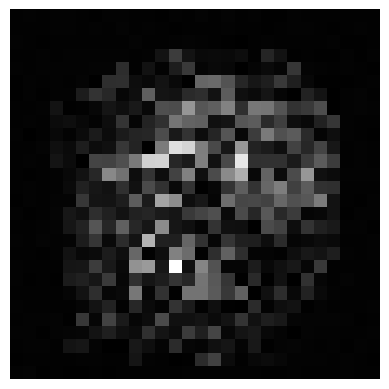

In [ ]:
# define model
model_l1 = MLP(regularizer_type='l1', train_loader=train_loader, test_loader=test_loader)
# train
model_l1.train(epochs=num_epochs, save=num_save)

l1_tr_acc = model_l1.train_accuracy_list
l1_te_acc = model_l1.test_accuracy_list

  1%|          | 1/100 [00:16<27:39, 16.77s/it]


Test Accuracy : 0.9265000224113464
Train Accuracy : 0.8568333387374878


  2%|▏         | 2/100 [00:33<26:58, 16.52s/it]


Test Accuracy : 0.9291999936103821
Train Accuracy : 0.934066653251648


  3%|▎         | 3/100 [00:50<27:07, 16.78s/it]


Test Accuracy : 0.9391000270843506
Train Accuracy : 0.9440500140190125


  4%|▍         | 4/100 [01:06<26:41, 16.68s/it]


Test Accuracy : 0.9472000002861023
Train Accuracy : 0.9503333568572998


  5%|▌         | 5/100 [01:23<26:13, 16.57s/it]


Test Accuracy : 0.954800009727478
Train Accuracy : 0.9531333446502686


  6%|▌         | 6/100 [01:40<26:11, 16.71s/it]


Test Accuracy : 0.9502999782562256
Train Accuracy : 0.9574333429336548


  7%|▋         | 7/100 [01:56<25:59, 16.77s/it]


Test Accuracy : 0.9491999745368958
Train Accuracy : 0.9549999833106995


  8%|▊         | 8/100 [02:16<26:57, 17.59s/it]


Test Accuracy : 0.9537000060081482
Train Accuracy : 0.9563833475112915


  9%|▉         | 9/100 [02:37<28:23, 18.72s/it]


Test Accuracy : 0.9498999714851379
Train Accuracy : 0.9601166844367981


 10%|█         | 10/100 [03:00<30:11, 20.13s/it]


Test Accuracy : 0.9476000070571899
Train Accuracy : 0.9592166543006897


 11%|█         | 11/100 [03:24<31:15, 21.07s/it]


Test Accuracy : 0.9506000280380249
Train Accuracy : 0.9599499702453613


 12%|█▏        | 12/100 [03:47<31:56, 21.78s/it]


Test Accuracy : 0.942799985408783
Train Accuracy : 0.9598666429519653


 13%|█▎        | 13/100 [04:10<32:19, 22.29s/it]


Test Accuracy : 0.9470999836921692
Train Accuracy : 0.9602166414260864


 14%|█▍        | 14/100 [04:34<32:26, 22.63s/it]


Test Accuracy : 0.9581999778747559
Train Accuracy : 0.9605166912078857


 15%|█▌        | 15/100 [04:57<32:23, 22.87s/it]


Test Accuracy : 0.9544000029563904
Train Accuracy : 0.9624666571617126


 16%|█▌        | 16/100 [05:21<32:36, 23.29s/it]


Test Accuracy : 0.9527000188827515
Train Accuracy : 0.9645666480064392


 17%|█▋        | 17/100 [05:46<32:52, 23.77s/it]


Test Accuracy : 0.9491999745368958
Train Accuracy : 0.9623500108718872


 18%|█▊        | 18/100 [06:12<33:03, 24.19s/it]


Test Accuracy : 0.958899974822998
Train Accuracy : 0.9643999934196472


 19%|█▉        | 19/100 [06:37<33:06, 24.52s/it]


Test Accuracy : 0.955299973487854
Train Accuracy : 0.9648500084877014


 20%|██        | 20/100 [07:03<33:10, 24.88s/it]


Test Accuracy : 0.949400007724762
Train Accuracy : 0.9639166593551636


 21%|██        | 21/100 [07:28<33:08, 25.17s/it]


Test Accuracy : 0.9480999708175659
Train Accuracy : 0.9649333357810974


 22%|██▏       | 22/100 [07:54<32:51, 25.27s/it]


Test Accuracy : 0.9598000049591064
Train Accuracy : 0.9635000228881836


 23%|██▎       | 23/100 [08:20<32:35, 25.40s/it]


Test Accuracy : 0.9559999704360962
Train Accuracy : 0.964816689491272


 24%|██▍       | 24/100 [08:46<32:39, 25.78s/it]


Test Accuracy : 0.9514999985694885
Train Accuracy : 0.965233325958252


 25%|██▌       | 25/100 [09:14<32:48, 26.25s/it]


Test Accuracy : 0.9581000208854675
Train Accuracy : 0.9656000137329102


 26%|██▌       | 26/100 [09:45<34:07, 27.67s/it]


Test Accuracy : 0.9573000073432922
Train Accuracy : 0.9648666381835938


 27%|██▋       | 27/100 [10:16<35:09, 28.90s/it]


Test Accuracy : 0.958899974822998
Train Accuracy : 0.9669166803359985


 28%|██▊       | 28/100 [10:49<36:08, 30.12s/it]


Test Accuracy : 0.9509000182151794
Train Accuracy : 0.9662666916847229


 29%|██▉       | 29/100 [11:24<37:15, 31.49s/it]


Test Accuracy : 0.9589999914169312
Train Accuracy : 0.9664499759674072


 30%|███       | 30/100 [11:59<37:55, 32.51s/it]


Test Accuracy : 0.9546999931335449
Train Accuracy : 0.9681833386421204


 31%|███       | 31/100 [12:35<38:46, 33.72s/it]


Test Accuracy : 0.9524999856948853
Train Accuracy : 0.9650499820709229


 32%|███▏      | 32/100 [13:13<39:31, 34.88s/it]


Test Accuracy : 0.9520000219345093
Train Accuracy : 0.9659500122070312


 33%|███▎      | 33/100 [13:51<40:01, 35.84s/it]


Test Accuracy : 0.9513999819755554
Train Accuracy : 0.9666666388511658


 34%|███▍      | 34/100 [14:30<40:27, 36.79s/it]


Test Accuracy : 0.9552000164985657
Train Accuracy : 0.9674999713897705


 35%|███▌      | 35/100 [15:09<40:40, 37.55s/it]


Test Accuracy : 0.9448000192642212
Train Accuracy : 0.9653666615486145


 36%|███▌      | 36/100 [15:49<40:49, 38.28s/it]


Test Accuracy : 0.9528999924659729
Train Accuracy : 0.9660166501998901


 37%|███▋      | 37/100 [16:30<40:50, 38.89s/it]


Test Accuracy : 0.9593999981880188
Train Accuracy : 0.9668833613395691


 38%|███▊      | 38/100 [17:11<40:57, 39.63s/it]


Test Accuracy : 0.9513000249862671
Train Accuracy : 0.9681833386421204


 39%|███▉      | 39/100 [17:53<40:51, 40.18s/it]


Test Accuracy : 0.9539999961853027
Train Accuracy : 0.9670000076293945


 40%|████      | 40/100 [18:37<41:31, 41.52s/it]


Test Accuracy : 0.9574000239372253
Train Accuracy : 0.9695666432380676


 41%|████      | 41/100 [19:22<41:51, 42.57s/it]


Test Accuracy : 0.9502999782562256
Train Accuracy : 0.9697666764259338


 42%|████▏     | 42/100 [20:09<42:19, 43.79s/it]


Test Accuracy : 0.9581999778747559
Train Accuracy : 0.9681833386421204


 43%|████▎     | 43/100 [20:57<42:48, 45.06s/it]


Test Accuracy : 0.95660001039505
Train Accuracy : 0.9674833416938782


 44%|████▍     | 44/100 [21:46<43:03, 46.14s/it]


Test Accuracy : 0.9553999900817871
Train Accuracy : 0.9680333137512207


 45%|████▌     | 45/100 [22:35<43:04, 46.99s/it]


Test Accuracy : 0.9574000239372253
Train Accuracy : 0.9657166600227356


 46%|████▌     | 46/100 [23:24<42:54, 47.67s/it]


Test Accuracy : 0.9557999968528748
Train Accuracy : 0.9669833183288574


 47%|████▋     | 47/100 [24:14<42:39, 48.30s/it]


Test Accuracy : 0.9555000066757202
Train Accuracy : 0.9682833552360535


 48%|████▊     | 48/100 [25:04<42:25, 48.95s/it]


Test Accuracy : 0.9506999850273132
Train Accuracy : 0.9698500037193298


 49%|████▉     | 49/100 [25:55<42:08, 49.58s/it]


Test Accuracy : 0.9541000127792358
Train Accuracy : 0.9668833613395691


 50%|█████     | 50/100 [26:47<41:55, 50.30s/it]


Test Accuracy : 0.9513999819755554
Train Accuracy : 0.9679333567619324


 51%|█████     | 51/100 [27:39<41:31, 50.84s/it]


Test Accuracy : 0.9570000171661377
Train Accuracy : 0.9672166705131531


 52%|█████▏    | 52/100 [28:31<40:52, 51.10s/it]


Test Accuracy : 0.9581999778747559
Train Accuracy : 0.9693333506584167


 53%|█████▎    | 53/100 [29:23<40:14, 51.36s/it]


Test Accuracy : 0.9570000171661377
Train Accuracy : 0.9705166816711426


 54%|█████▍    | 54/100 [30:15<39:32, 51.58s/it]


Test Accuracy : 0.949999988079071
Train Accuracy : 0.9716833233833313


 55%|█████▌    | 55/100 [31:08<38:55, 51.89s/it]


Test Accuracy : 0.9509000182151794
Train Accuracy : 0.9661666750907898


 56%|█████▌    | 56/100 [32:00<38:08, 52.01s/it]


Test Accuracy : 0.953000009059906
Train Accuracy : 0.9697833061218262


 57%|█████▋    | 57/100 [32:52<37:19, 52.08s/it]


Test Accuracy : 0.9516000151634216
Train Accuracy : 0.9694666862487793


 58%|█████▊    | 58/100 [33:44<36:31, 52.18s/it]


Test Accuracy : 0.9544000029563904
Train Accuracy : 0.9678666591644287


 59%|█████▉    | 59/100 [34:38<35:51, 52.47s/it]


Test Accuracy : 0.9562000036239624
Train Accuracy : 0.9691166877746582


 60%|██████    | 60/100 [35:30<35:03, 52.58s/it]


Test Accuracy : 0.9623000025749207
Train Accuracy : 0.9720333218574524


 61%|██████    | 61/100 [36:24<34:19, 52.81s/it]


Test Accuracy : 0.9534000158309937
Train Accuracy : 0.9717333316802979


 62%|██████▏   | 62/100 [37:18<33:41, 53.21s/it]


Test Accuracy : 0.9550999999046326
Train Accuracy : 0.9710000157356262


 63%|██████▎   | 63/100 [38:12<32:52, 53.32s/it]


Test Accuracy : 0.9567999839782715
Train Accuracy : 0.9683666825294495


 64%|██████▍   | 64/100 [39:05<32:02, 53.40s/it]


Test Accuracy : 0.9585000276565552
Train Accuracy : 0.9725000262260437


 65%|██████▌   | 65/100 [39:59<31:18, 53.66s/it]


Test Accuracy : 0.9523000121116638
Train Accuracy : 0.9689000248908997


 66%|██████▌   | 66/100 [40:53<30:24, 53.67s/it]


Test Accuracy : 0.9585000276565552
Train Accuracy : 0.9685166478157043


 67%|██████▋   | 67/100 [41:47<29:34, 53.77s/it]


Test Accuracy : 0.9476000070571899
Train Accuracy : 0.9718499779701233


 68%|██████▊   | 68/100 [42:41<28:42, 53.84s/it]


Test Accuracy : 0.9584000110626221
Train Accuracy : 0.9742333292961121


 69%|██████▉   | 69/100 [43:35<27:47, 53.79s/it]


Test Accuracy : 0.9560999870300293
Train Accuracy : 0.9657999873161316


 70%|███████   | 70/100 [44:29<26:59, 54.00s/it]


Test Accuracy : 0.9559000134468079
Train Accuracy : 0.9718000292778015


 71%|███████   | 71/100 [45:23<26:03, 53.91s/it]


Test Accuracy : 0.9532999992370605
Train Accuracy : 0.9700833559036255


 72%|███████▏  | 72/100 [46:17<25:07, 53.85s/it]


Test Accuracy : 0.9531000256538391
Train Accuracy : 0.9721166491508484


 73%|███████▎  | 73/100 [47:11<24:16, 53.96s/it]


Test Accuracy : 0.9513000249862671
Train Accuracy : 0.9725666642189026


 74%|███████▍  | 74/100 [48:05<23:20, 53.88s/it]


Test Accuracy : 0.9567999839782715
Train Accuracy : 0.9723833203315735


 75%|███████▌  | 75/100 [48:59<22:28, 53.96s/it]


Test Accuracy : 0.9553999900817871
Train Accuracy : 0.970716655254364


 76%|███████▌  | 76/100 [49:53<21:34, 53.92s/it]


Test Accuracy : 0.9588000178337097
Train Accuracy : 0.9727166891098022


 77%|███████▋  | 77/100 [50:46<20:38, 53.86s/it]


Test Accuracy : 0.953000009059906
Train Accuracy : 0.9717333316802979


 78%|███████▊  | 78/100 [51:41<19:48, 54.01s/it]


Test Accuracy : 0.954800009727478
Train Accuracy : 0.9706166386604309


 79%|███████▉  | 79/100 [52:34<18:52, 53.95s/it]


Test Accuracy : 0.9591000080108643
Train Accuracy : 0.9694166779518127


 80%|████████  | 80/100 [53:29<18:00, 54.01s/it]


Test Accuracy : 0.9506999850273132
Train Accuracy : 0.9720333218574524


 81%|████████  | 81/100 [54:23<17:06, 54.04s/it]


Test Accuracy : 0.9571999907493591
Train Accuracy : 0.9736999869346619


 82%|████████▏ | 82/100 [55:16<16:10, 53.93s/it]


Test Accuracy : 0.9538000226020813
Train Accuracy : 0.9703333377838135


 83%|████████▎ | 83/100 [56:11<15:18, 54.04s/it]


Test Accuracy : 0.95169997215271
Train Accuracy : 0.9711333513259888


 84%|████████▍ | 84/100 [57:04<14:23, 53.95s/it]


Test Accuracy : 0.9527999758720398
Train Accuracy : 0.9732833504676819


 85%|████████▌ | 85/100 [57:58<13:28, 53.88s/it]


Test Accuracy : 0.9412000179290771
Train Accuracy : 0.9700833559036255


 86%|████████▌ | 86/100 [58:52<12:35, 54.00s/it]


Test Accuracy : 0.9532999992370605
Train Accuracy : 0.9699500203132629


 87%|████████▋ | 87/100 [59:46<11:40, 53.92s/it]


Test Accuracy : 0.9467999935150146
Train Accuracy : 0.9711666703224182


 88%|████████▊ | 88/100 [1:00:40<10:47, 53.97s/it]


Test Accuracy : 0.9546999931335449
Train Accuracy : 0.9718999862670898


 89%|████████▉ | 89/100 [1:01:34<09:53, 53.96s/it]


Test Accuracy : 0.9571999907493591
Train Accuracy : 0.9740166664123535


 90%|█████████ | 90/100 [1:02:28<08:59, 53.95s/it]


Test Accuracy : 0.9501000046730042
Train Accuracy : 0.9732000231742859


 91%|█████████ | 91/100 [1:03:22<08:06, 54.04s/it]


Test Accuracy : 0.9546999931335449
Train Accuracy : 0.9713500142097473


 92%|█████████▏| 92/100 [1:04:16<07:11, 53.94s/it]


Test Accuracy : 0.9496999979019165
Train Accuracy : 0.9747166633605957


 93%|█████████▎| 93/100 [1:05:10<06:17, 53.91s/it]


Test Accuracy : 0.9501000046730042
Train Accuracy : 0.9751833081245422


 94%|█████████▍| 94/100 [1:06:04<05:23, 53.98s/it]


Test Accuracy : 0.9552000164985657
Train Accuracy : 0.9721166491508484


 95%|█████████▌| 95/100 [1:06:58<04:29, 53.93s/it]


Test Accuracy : 0.9559999704360962
Train Accuracy : 0.9714166522026062


 96%|█████████▌| 96/100 [1:07:52<03:36, 54.04s/it]


Test Accuracy : 0.95660001039505
Train Accuracy : 0.9705166816711426


 97%|█████████▋| 97/100 [1:08:46<02:41, 53.93s/it]


Test Accuracy : 0.9502999782562256
Train Accuracy : 0.97243332862854


 98%|█████████▊| 98/100 [1:09:40<01:47, 53.86s/it]


Test Accuracy : 0.9544000029563904
Train Accuracy : 0.9728999733924866


 99%|█████████▉| 99/100 [1:10:34<00:53, 53.98s/it]


Test Accuracy : 0.9573000073432922
Train Accuracy : 0.9724500179290771


100%|██████████| 100/100 [1:11:28<00:00, 42.88s/it]


Test Accuracy : 0.9562000036239624
Train Accuracy : 0.9726499915122986


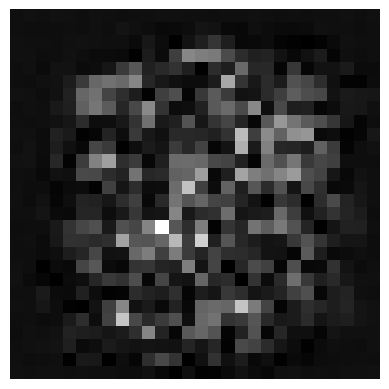

In [ ]:
# define model
model_l2 = MLP(regularizer_type='l2', train_loader=train_loader, test_loader=test_loader)
# train
model_l2.train(epochs=num_epochs, save=num_save)

l2_tr_acc = model_l2.train_accuracy_list
l2_te_acc = model_l2.test_accuracy_list

  1%|          | 1/100 [00:17<29:13, 17.71s/it]


Test Accuracy : 0.9318000078201294
Train Accuracy : 0.8590666651725769


  2%|▏         | 2/100 [00:34<28:05, 17.20s/it]


Test Accuracy : 0.935699999332428
Train Accuracy : 0.9367499947547913


  3%|▎         | 3/100 [00:51<27:31, 17.03s/it]


Test Accuracy : 0.948199987411499
Train Accuracy : 0.9458333253860474


  4%|▍         | 4/100 [01:09<27:45, 17.34s/it]


Test Accuracy : 0.9502000212669373
Train Accuracy : 0.9527833461761475


  5%|▌         | 5/100 [01:26<27:10, 17.16s/it]


Test Accuracy : 0.9516000151634216
Train Accuracy : 0.9556499719619751


  6%|▌         | 6/100 [01:42<26:41, 17.04s/it]


Test Accuracy : 0.9549000263214111
Train Accuracy : 0.9557999968528748


  7%|▋         | 7/100 [02:00<26:39, 17.20s/it]


Test Accuracy : 0.9429000020027161
Train Accuracy : 0.9593333601951599


  8%|▊         | 8/100 [02:17<26:10, 17.07s/it]


Test Accuracy : 0.9570000171661377
Train Accuracy : 0.9594333171844482


  9%|▉         | 9/100 [02:34<25:48, 17.01s/it]


Test Accuracy : 0.955299973487854
Train Accuracy : 0.9608666896820068


 10%|█         | 10/100 [02:51<25:47, 17.19s/it]


Test Accuracy : 0.9598000049591064
Train Accuracy : 0.9620833396911621


 11%|█         | 11/100 [03:08<25:17, 17.05s/it]


Test Accuracy : 0.9557999968528748
Train Accuracy : 0.962149977684021


 12%|█▏        | 12/100 [03:25<25:15, 17.22s/it]


Test Accuracy : 0.9539999961853027
Train Accuracy : 0.963699996471405


 13%|█▎        | 13/100 [03:42<24:46, 17.09s/it]


Test Accuracy : 0.9567000269889832
Train Accuracy : 0.963366687297821


 14%|█▍        | 14/100 [03:59<24:20, 16.98s/it]


Test Accuracy : 0.9562000036239624
Train Accuracy : 0.9627500176429749


 15%|█▌        | 15/100 [04:17<24:19, 17.18s/it]


Test Accuracy : 0.955299973487854
Train Accuracy : 0.9663500189781189


 16%|█▌        | 16/100 [04:33<23:51, 17.04s/it]


Test Accuracy : 0.9539999961853027
Train Accuracy : 0.9668499827384949


 17%|█▋        | 17/100 [04:50<23:25, 16.93s/it]


Test Accuracy : 0.9598000049591064
Train Accuracy : 0.9659833312034607


 18%|█▊        | 18/100 [05:08<23:23, 17.11s/it]


Test Accuracy : 0.9556000232696533
Train Accuracy : 0.9637666940689087


 19%|█▉        | 19/100 [05:24<22:56, 16.99s/it]


Test Accuracy : 0.9631999731063843
Train Accuracy : 0.9657999873161316


 20%|██        | 20/100 [05:42<22:48, 17.11s/it]


Test Accuracy : 0.9542999863624573
Train Accuracy : 0.9674166440963745


 21%|██        | 21/100 [05:59<22:33, 17.14s/it]


Test Accuracy : 0.9606000185012817
Train Accuracy : 0.9692333340644836


 22%|██▏       | 22/100 [06:16<22:07, 17.02s/it]


Test Accuracy : 0.9538000226020813
Train Accuracy : 0.9675833582878113


 23%|██▎       | 23/100 [06:33<22:02, 17.18s/it]


Test Accuracy : 0.9574999809265137
Train Accuracy : 0.9659500122070312


 24%|██▍       | 24/100 [06:50<21:37, 17.07s/it]


Test Accuracy : 0.9581000208854675
Train Accuracy : 0.9691500067710876


 25%|██▌       | 25/100 [07:07<21:13, 16.98s/it]


Test Accuracy : 0.958899974822998
Train Accuracy : 0.9684666395187378


 26%|██▌       | 26/100 [07:24<21:10, 17.17s/it]


Test Accuracy : 0.9557999968528748
Train Accuracy : 0.9686999917030334


 27%|██▋       | 27/100 [07:41<20:44, 17.05s/it]


Test Accuracy : 0.9503999948501587
Train Accuracy : 0.9682999849319458


 28%|██▊       | 28/100 [07:58<20:19, 16.94s/it]


Test Accuracy : 0.9567999839782715
Train Accuracy : 0.9692166447639465


 29%|██▉       | 29/100 [08:15<20:16, 17.13s/it]


Test Accuracy : 0.9574000239372253
Train Accuracy : 0.968833327293396


 30%|███       | 30/100 [08:32<19:54, 17.06s/it]


Test Accuracy : 0.9480000138282776
Train Accuracy : 0.9703500270843506


 31%|███       | 31/100 [08:49<19:37, 17.06s/it]


Test Accuracy : 0.958299994468689
Train Accuracy : 0.9678000211715698


 32%|███▏      | 32/100 [09:07<19:23, 17.11s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9701666831970215


 33%|███▎      | 33/100 [09:23<18:58, 17.00s/it]


Test Accuracy : 0.9591000080108643
Train Accuracy : 0.9686999917030334


 34%|███▍      | 34/100 [09:41<18:52, 17.16s/it]


Test Accuracy : 0.9567000269889832
Train Accuracy : 0.9715333580970764


 35%|███▌      | 35/100 [09:57<18:25, 17.00s/it]


Test Accuracy : 0.9631999731063843
Train Accuracy : 0.9715333580970764


 36%|███▌      | 36/100 [10:14<18:03, 16.94s/it]


Test Accuracy : 0.9611999988555908
Train Accuracy : 0.9712666869163513


 37%|███▋      | 37/100 [10:32<17:59, 17.14s/it]


Test Accuracy : 0.9563000202178955
Train Accuracy : 0.9712833166122437


 38%|███▊      | 38/100 [10:49<17:36, 17.04s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9704333543777466


 39%|███▉      | 39/100 [11:05<17:13, 16.94s/it]


Test Accuracy : 0.9589999914169312
Train Accuracy : 0.9714666604995728


 40%|████      | 40/100 [11:23<17:12, 17.20s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9711833596229553


 41%|████      | 41/100 [11:40<16:47, 17.07s/it]


Test Accuracy : 0.9567999839782715
Train Accuracy : 0.9729833602905273


 42%|████▏     | 42/100 [11:57<16:29, 17.06s/it]


Test Accuracy : 0.9599000215530396
Train Accuracy : 0.9713166952133179


 43%|████▎     | 43/100 [12:14<16:15, 17.12s/it]


Test Accuracy : 0.9570000171661377
Train Accuracy : 0.9728833436965942


 44%|████▍     | 44/100 [12:31<15:51, 16.99s/it]


Test Accuracy : 0.9606999754905701
Train Accuracy : 0.974216639995575


 45%|████▌     | 45/100 [12:49<15:44, 17.18s/it]


Test Accuracy : 0.9587000012397766
Train Accuracy : 0.9713333249092102


 46%|████▌     | 46/100 [13:05<15:20, 17.05s/it]


Test Accuracy : 0.9603999853134155
Train Accuracy : 0.9730333089828491


 47%|████▋     | 47/100 [13:22<14:58, 16.96s/it]


Test Accuracy : 0.9563000202178955
Train Accuracy : 0.9725666642189026


 48%|████▊     | 48/100 [13:40<14:51, 17.14s/it]


Test Accuracy : 0.9610999822616577
Train Accuracy : 0.971916675567627


 49%|████▉     | 49/100 [13:56<14:28, 17.02s/it]


Test Accuracy : 0.9538000226020813
Train Accuracy : 0.971666693687439


 50%|█████     | 50/100 [14:13<14:11, 17.02s/it]


Test Accuracy : 0.9562000036239624
Train Accuracy : 0.9721666574478149


 51%|█████     | 51/100 [14:31<14:02, 17.19s/it]


Test Accuracy : 0.9603000283241272
Train Accuracy : 0.9742333292961121


 52%|█████▏    | 52/100 [14:48<13:39, 17.07s/it]


Test Accuracy : 0.9553999900817871
Train Accuracy : 0.9732000231742859


 53%|█████▎    | 53/100 [15:05<13:21, 17.05s/it]


Test Accuracy : 0.9578999876976013
Train Accuracy : 0.9735000133514404


 54%|█████▍    | 54/100 [15:22<13:08, 17.13s/it]


Test Accuracy : 0.9498000144958496
Train Accuracy : 0.9738333225250244


 55%|█████▌    | 55/100 [15:39<12:45, 17.02s/it]


Test Accuracy : 0.9628000259399414
Train Accuracy : 0.973883330821991


 56%|█████▌    | 56/100 [15:57<12:37, 17.22s/it]


Test Accuracy : 0.9567000269889832
Train Accuracy : 0.9729999899864197


 57%|█████▋    | 57/100 [16:13<12:14, 17.09s/it]


Test Accuracy : 0.9646000266075134
Train Accuracy : 0.973966658115387


 58%|█████▊    | 58/100 [16:30<11:53, 16.99s/it]


Test Accuracy : 0.954200029373169
Train Accuracy : 0.9728166460990906


 59%|█████▉    | 59/100 [16:48<11:43, 17.16s/it]


Test Accuracy : 0.9610999822616577
Train Accuracy : 0.974399983882904


 60%|██████    | 60/100 [17:05<11:23, 17.10s/it]


Test Accuracy : 0.9603999853134155
Train Accuracy : 0.9734500050544739


 61%|██████    | 61/100 [17:21<11:02, 16.99s/it]


Test Accuracy : 0.9574999809265137
Train Accuracy : 0.9748666882514954


 62%|██████▏   | 62/100 [17:39<10:51, 17.16s/it]


Test Accuracy : 0.9545999765396118
Train Accuracy : 0.975849986076355


 63%|██████▎   | 63/100 [17:56<10:29, 17.03s/it]


Test Accuracy : 0.9556000232696533
Train Accuracy : 0.9731333255767822


 64%|██████▍   | 64/100 [18:13<10:14, 17.06s/it]


Test Accuracy : 0.9545999765396118
Train Accuracy : 0.9744499921798706


 65%|██████▌   | 65/100 [18:30<09:58, 17.11s/it]


Test Accuracy : 0.9559000134468079
Train Accuracy : 0.9759833216667175


 66%|██████▌   | 66/100 [18:47<09:38, 17.01s/it]


Test Accuracy : 0.9617999792098999
Train Accuracy : 0.9746999740600586


 67%|██████▋   | 67/100 [19:04<09:27, 17.20s/it]


Test Accuracy : 0.960099995136261
Train Accuracy : 0.97243332862854


 68%|██████▊   | 68/100 [19:21<09:06, 17.07s/it]


Test Accuracy : 0.9614999890327454
Train Accuracy : 0.9745333194732666


 69%|██████▉   | 69/100 [19:38<08:46, 16.97s/it]


Test Accuracy : 0.9544000029563904
Train Accuracy : 0.9738666415214539


 70%|███████   | 70/100 [19:56<08:36, 17.22s/it]


Test Accuracy : 0.961899995803833
Train Accuracy : 0.9752833247184753


 71%|███████   | 71/100 [20:12<08:15, 17.08s/it]


Test Accuracy : 0.9617000222206116
Train Accuracy : 0.9753833413124084


 72%|███████▏  | 72/100 [20:29<07:55, 16.97s/it]


Test Accuracy : 0.9625999927520752
Train Accuracy : 0.9746999740600586


 73%|███████▎  | 73/100 [20:47<07:43, 17.18s/it]


Test Accuracy : 0.9606999754905701
Train Accuracy : 0.9750999808311462


 74%|███████▍  | 74/100 [21:04<07:23, 17.06s/it]


Test Accuracy : 0.957099974155426
Train Accuracy : 0.9779333472251892


 75%|███████▌  | 75/100 [21:21<07:08, 17.13s/it]


Test Accuracy : 0.9571999907493591
Train Accuracy : 0.9779333472251892


 76%|███████▌  | 76/100 [21:38<06:50, 17.12s/it]


Test Accuracy : 0.9556999802589417
Train Accuracy : 0.9754666686058044


 77%|███████▋  | 77/100 [21:55<06:31, 17.01s/it]


Test Accuracy : 0.9574999809265137
Train Accuracy : 0.9752500057220459


 78%|███████▊  | 78/100 [22:12<06:18, 17.19s/it]


Test Accuracy : 0.9559000134468079
Train Accuracy : 0.9778500199317932


 79%|███████▉  | 79/100 [22:29<05:58, 17.06s/it]


Test Accuracy : 0.9577999711036682
Train Accuracy : 0.9767833352088928


 80%|████████  | 80/100 [22:46<05:40, 17.04s/it]


Test Accuracy : 0.9502999782562256
Train Accuracy : 0.9746000170707703


 81%|████████  | 81/100 [23:04<05:26, 17.20s/it]


Test Accuracy : 0.9623000025749207
Train Accuracy : 0.9781666398048401


 82%|████████▏ | 82/100 [23:20<05:07, 17.08s/it]


Test Accuracy : 0.9588000178337097
Train Accuracy : 0.9746333360671997


 83%|████████▎ | 83/100 [23:37<04:49, 17.02s/it]


Test Accuracy : 0.9545999765396118
Train Accuracy : 0.9757999777793884


 84%|████████▍ | 84/100 [23:55<04:34, 17.16s/it]


Test Accuracy : 0.9580000042915344
Train Accuracy : 0.975600004196167


 85%|████████▌ | 85/100 [24:12<04:15, 17.06s/it]


Test Accuracy : 0.9549999833106995
Train Accuracy : 0.9749333262443542


 86%|████████▌ | 86/100 [24:29<04:00, 17.16s/it]


Test Accuracy : 0.9575999975204468
Train Accuracy : 0.9776666760444641


 87%|████████▋ | 87/100 [24:46<03:42, 17.12s/it]


Test Accuracy : 0.9634000062942505
Train Accuracy : 0.9791666865348816


 88%|████████▊ | 88/100 [25:03<03:24, 17.03s/it]


Test Accuracy : 0.9592999815940857
Train Accuracy : 0.9766166806221008


 89%|████████▉ | 89/100 [25:21<03:09, 17.22s/it]


Test Accuracy : 0.9595000147819519
Train Accuracy : 0.975766658782959


 90%|█████████ | 90/100 [25:38<02:51, 17.15s/it]


Test Accuracy : 0.9609000086784363
Train Accuracy : 0.979033350944519


 91%|█████████ | 91/100 [25:54<02:33, 17.05s/it]


Test Accuracy : 0.9617999792098999
Train Accuracy : 0.978600025177002


 92%|█████████▏| 92/100 [26:12<02:17, 17.24s/it]


Test Accuracy : 0.9550999999046326
Train Accuracy : 0.9775000214576721


 93%|█████████▎| 93/100 [26:29<01:59, 17.11s/it]


Test Accuracy : 0.9602000117301941
Train Accuracy : 0.9765333533287048


 94%|█████████▍| 94/100 [26:46<01:42, 17.16s/it]


Test Accuracy : 0.9559999704360962
Train Accuracy : 0.978766679763794


 95%|█████████▌| 95/100 [27:03<01:25, 17.18s/it]


Test Accuracy : 0.9588000178337097
Train Accuracy : 0.9751166701316833


 96%|█████████▌| 96/100 [27:20<01:08, 17.05s/it]


Test Accuracy : 0.955299973487854
Train Accuracy : 0.9766333103179932


 97%|█████████▋| 97/100 [27:38<00:51, 17.21s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9779999852180481


 98%|█████████▊| 98/100 [27:54<00:34, 17.08s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9781500101089478


 99%|█████████▉| 99/100 [28:11<00:16, 16.99s/it]


Test Accuracy : 0.9567999839782715
Train Accuracy : 0.9775166511535645


100%|██████████| 100/100 [28:29<00:00, 17.10s/it]


Test Accuracy : 0.9603999853134155
Train Accuracy : 0.9779499769210815


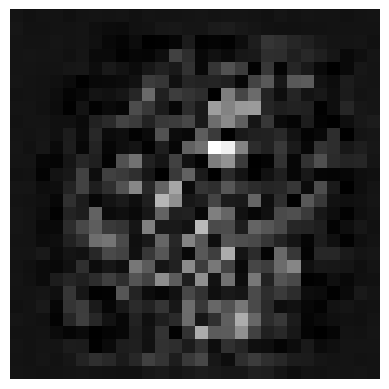

In [ ]:
# define model
model_l3 = MLP(regularizer_type='l3', train_loader=train_loader, test_loader=test_loader)
# train
model_l3.train(epochs=num_epochs, save=num_save)

l3_tr_acc = model_l3.train_accuracy_list
l3_te_acc = model_l3.test_accuracy_list

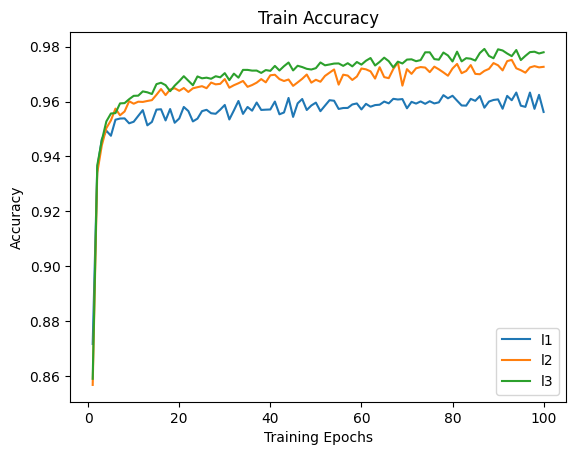

In [ ]:
# plot accuracy progress
plt.title("Train Accuracy")
plt.plot(range(1,num_epochs+1),l1_tr_acc,label="l1")
plt.plot(range(1,num_epochs+1),l2_tr_acc,label="l2")
plt.plot(range(1,num_epochs+1),l3_tr_acc,label="l3")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

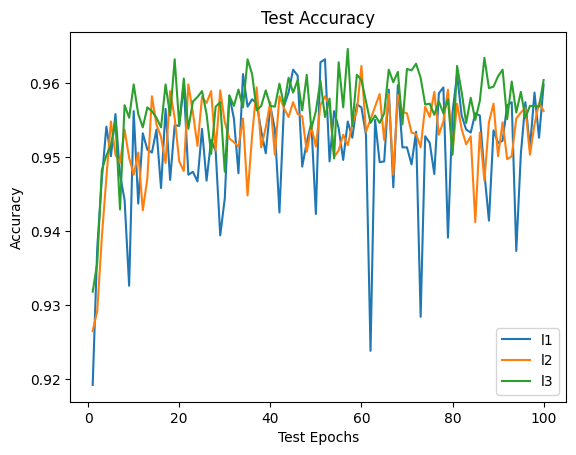

In [ ]:
plt.title("Test Accuracy")
plt.plot(range(1,num_epochs+1),l1_te_acc,label="l1")
plt.plot(range(1,num_epochs+1),l2_te_acc,label="l2")
plt.plot(range(1,num_epochs+1),l3_te_acc,label="l3")
plt.ylabel("Accuracy")
plt.xlabel("Test Epochs")
plt.legend()
plt.show()

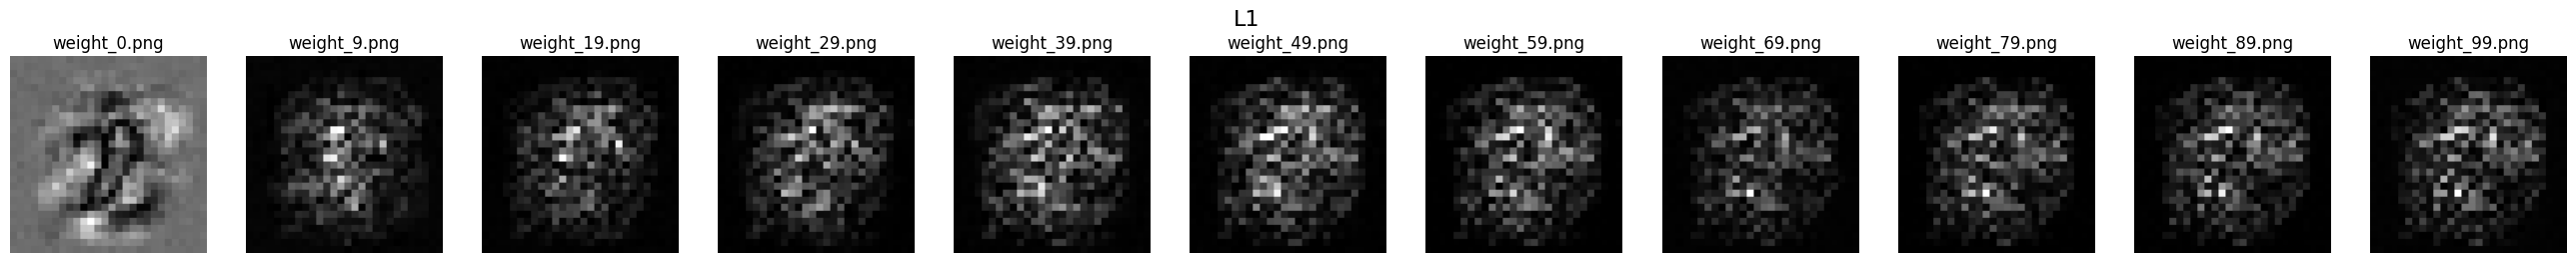

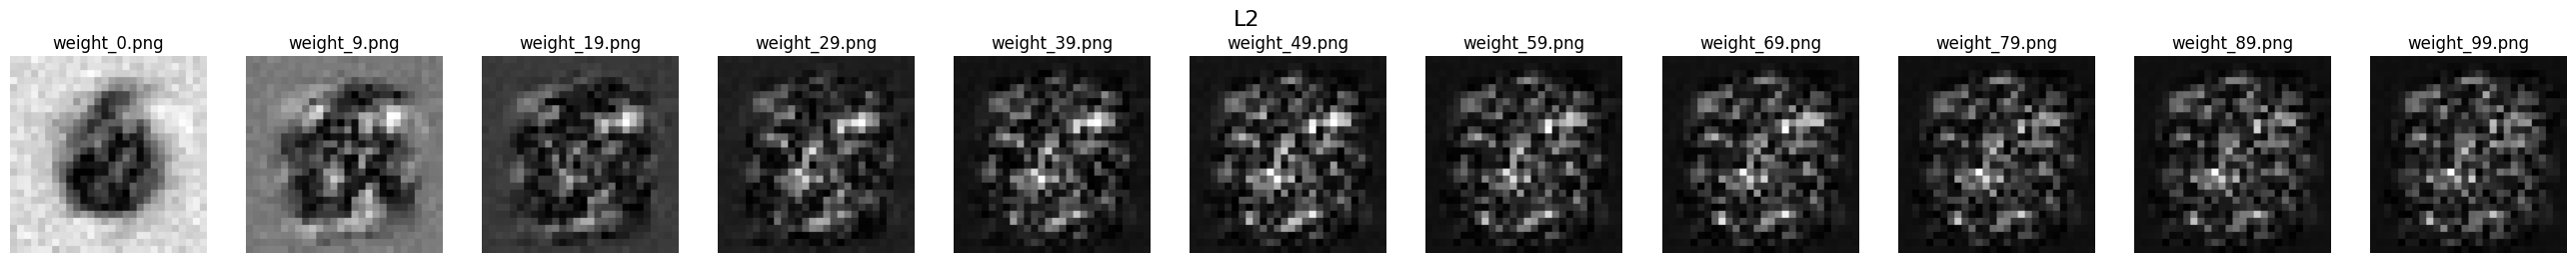

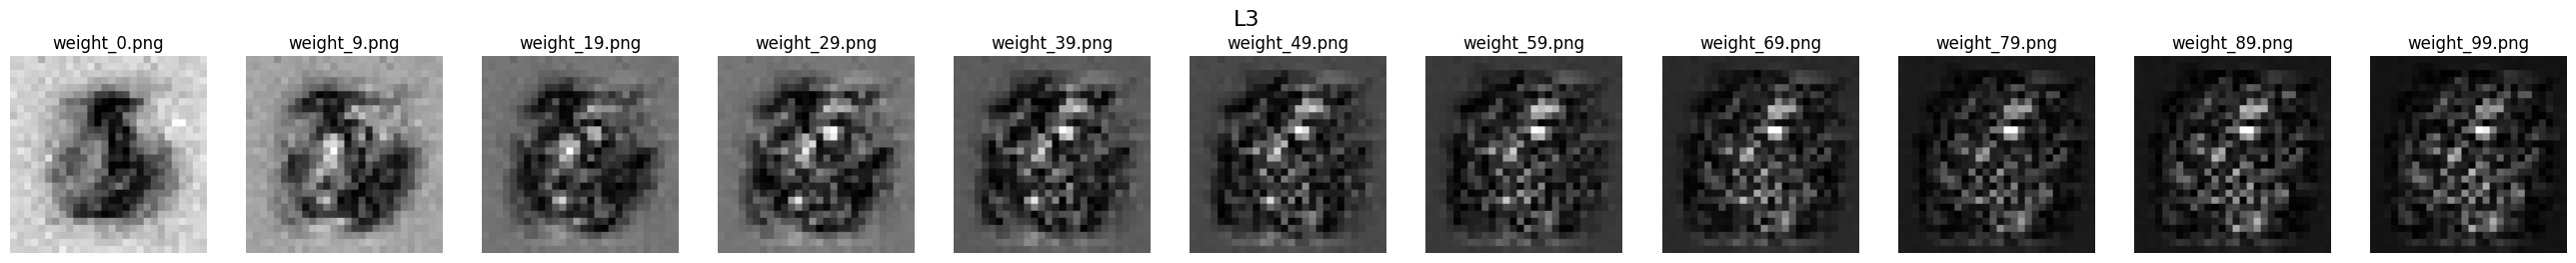

In [ ]:
def plot_images_from_subdirs(base_dir):
    for subdir, _, files in sorted(os.walk(base_dir)):
        image_files = sorted([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
        image_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
        if image_files:
            images = []
            for image_file in image_files:
                img_path = os.path.join(subdir, image_file)
                img = Image.open(img_path)
                images.append(img)

            num_images = len(images)
            fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))
            plt.suptitle(os.path.basename(subdir), fontsize=16)
            if num_images == 1:
                axes = [axes]

            for ax, img, file_name in zip(axes, images, image_files):
                ax.imshow(img)
                ax.set_title(file_name)
                ax.axis('off')

            plt.show()

plot_images_from_subdirs(base_dir)